In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
plt.style.use('style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

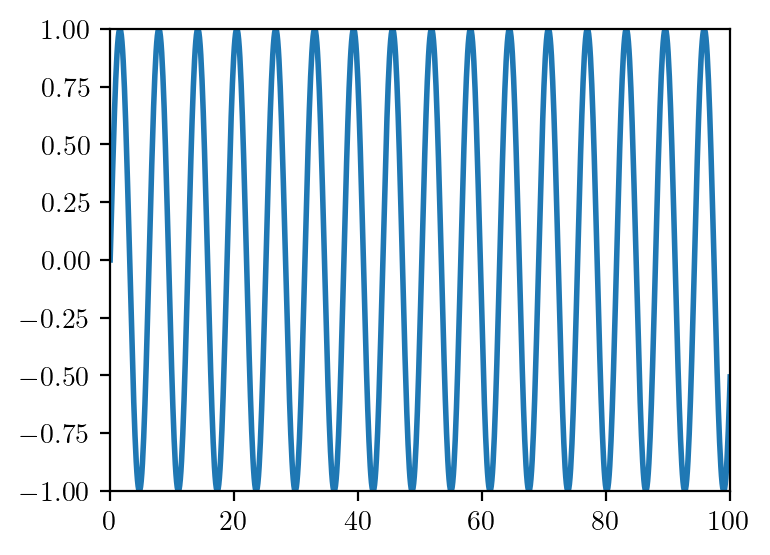

In [6]:
x = np.linspace(0,100,1000)

plt.figure()
plt.plot(x,np.sin(x))
plt.show()